In [1]:
## Install pmdarima if not installed

#!pip install pmdarima

## Import Packages

In [2]:
#Importing the Libraries

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mandates
from keras.utils.vis_utils import plot_model
from pandas.plotting import lag_plot
from datetime import datetime
from datetime import date
import yfinance as yf
import os
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


## Data Collection

[*********************100%***********************]  1 of 1 completed


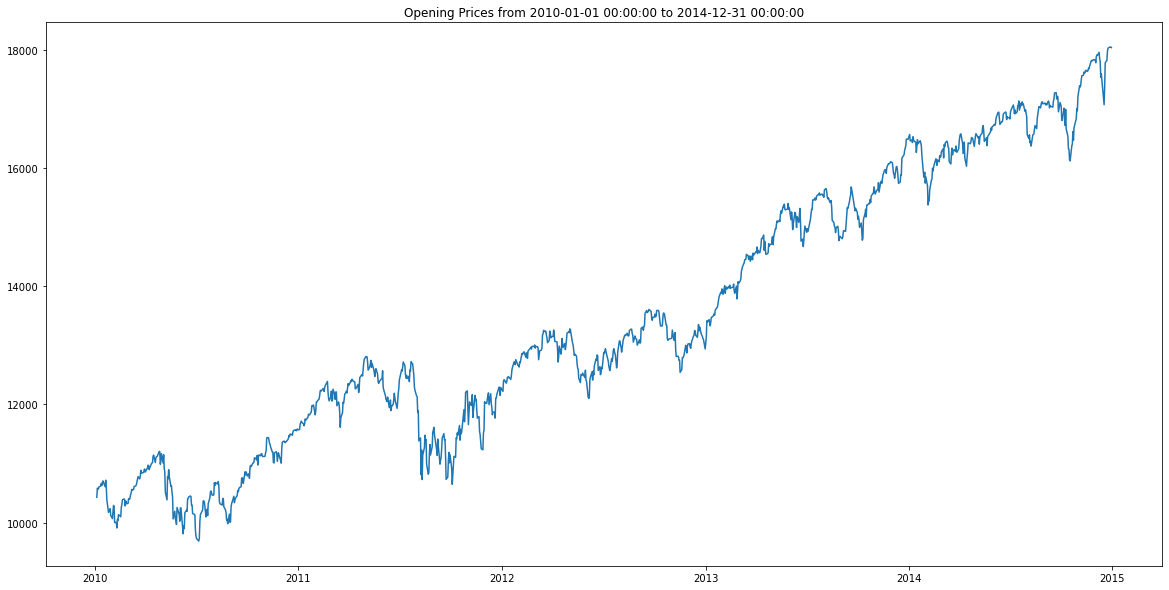

In [3]:
# Select date range
start_date = datetime(2010, 1, 1)
#end_date = date.today()
end_date = datetime(2014, 12, 31)
  
# Download ticker data from Yahoo Finance
ticker = 'DJIA'
data = yf.download(ticker, start = start_date,
                   end = end_date)
  
# Visualization
plt.figure(figsize = (20,10))
plt.title('Opening Prices from {} to {}'.format(start_date,
                                                end_date))
plt.plot(data['Open'])
plt.show()

In [4]:
## Preview Data
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,10430.690430,10641.620117,10430.690430,10583.959961,10583.959961,3991400000
2010-01-05,10584.559570,10647.139648,10468.860352,10572.019531,10572.019531,2491020000
2010-01-06,10564.719727,10655.219727,10488.280273,10573.679688,10573.679688,4972660000
2010-01-07,10571.110352,10655.599609,10471.730469,10606.860352,10606.860352,5270680000
2010-01-08,10606.400391,10653.110352,10509.740234,10618.190430,10618.190430,4389590000


In [5]:
## Select Target Column
target = 'Open'
df = pd.DataFrame(data[target])
df

,Open
Date,
2010-01-04,10430.690430
2010-01-05,10584.559570
2010-01-06,10564.719727
2010-01-07,10571.110352
2010-01-08,10606.400391
...,...
2014-12-23,17971.509766
2014-12-24,18024.169922
2014-12-26,18038.300781


## Stationarity

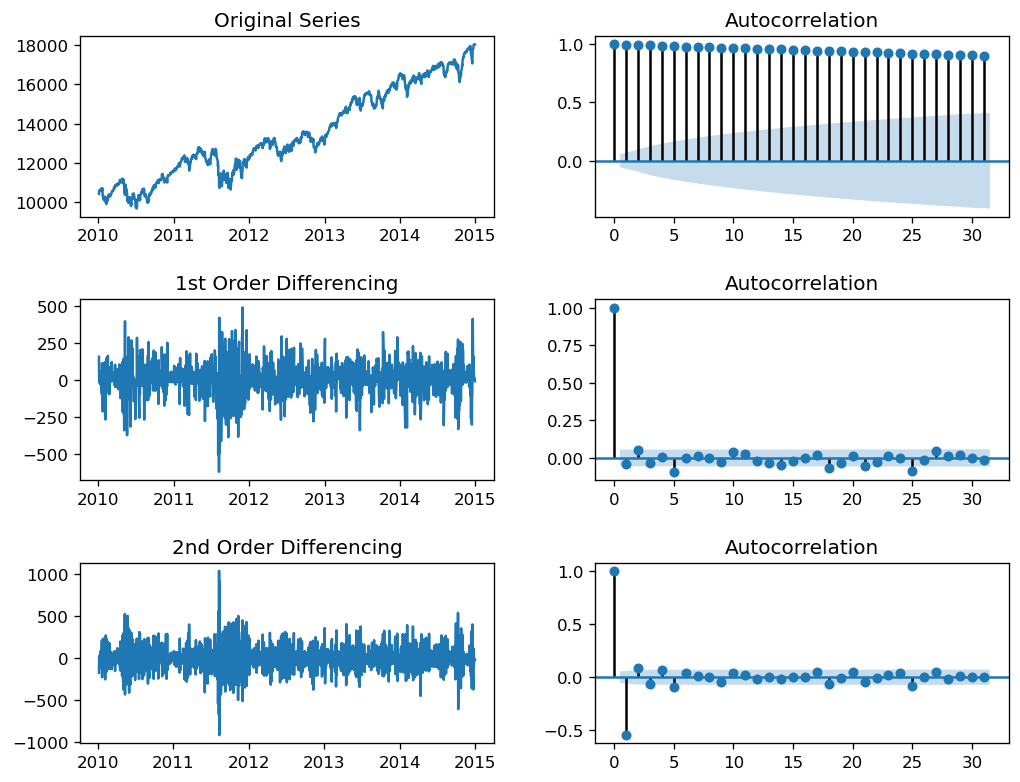

In [6]:
## Let's take a look at the 0, 1, 2 order differentials
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
fig.tight_layout(pad=3.0)
axes[0, 0].plot(df); axes[0, 0].set_title('Original Series')
plot_acf(df, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.diff().diff().dropna(), ax=axes[2, 1])

plt.show()


## It looks like the time series becomes stationary with 1st order differencing. But let's confirm with adfuller test.

In [7]:
## ADFuller test for stationarity for the original series. P-value is high, so series is not stationary.
adft = adfuller(df)
output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output)

Test Statistics                  -0.040618
p-value                           0.955041
No. of lags used                  5.000000
Number of observations used    1251.000000
critical value (1%)              -3.435588
critical value (5%)              -2.863853
critical value (10%)             -2.568002
dtype: float64


In [8]:
## ADFuller test for stationarity for the 1st order differentiated series. P-value is close to 0, it confirms stationarity.
adft = adfuller(df.diff().dropna())
output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output)

Test Statistics               -1.733603e+01
p-value                        5.374707e-30
No. of lags used               4.000000e+00
Number of observations used    1.251000e+03
critical value (1%)           -3.435588e+00
critical value (5%)           -2.863853e+00
critical value (10%)          -2.568002e+00
dtype: float64


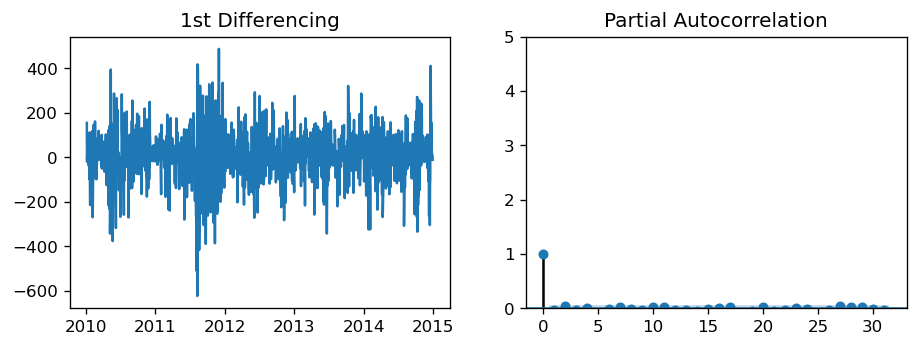

In [9]:
# Let's look at the PACF plot of 1st differenced series. We can figure out how many AR lags are necessary for our ARIMA model.
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(df.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.diff().dropna(), ax=axes[1])

plt.show()

## lag 2 apperas to be significant or very close. Let's assume p=2

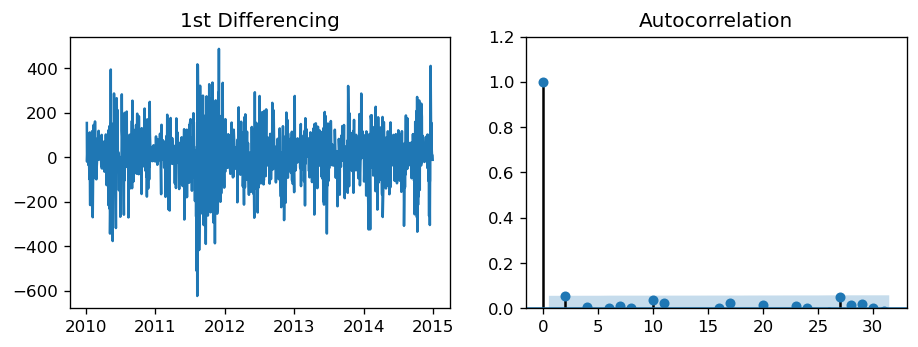

In [10]:
# Now let's look at the ACF plot of 1st differenced series. 
# We can figure out how many MA lags are necessary for our ARIMA model.
fig, axes = plt.subplots(1, 2)
axes[0].plot(df.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.diff().dropna(), ax=axes[1])

plt.show()

## Lag 2 appears to be significant or very close. Let's assume q is also 2.

## Train/Test Split

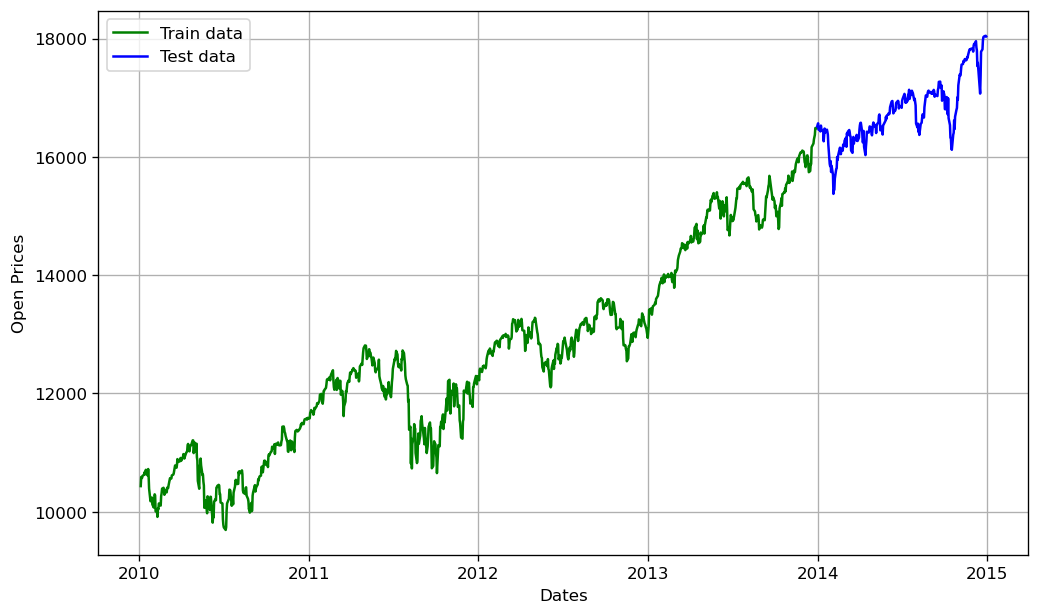

In [11]:
## Now before modeling, let's split data into train and training set.
train_pct = 0.8
train, test = df[:int(len(df)*train_pct)], df[int(len(df)*train_pct):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')

plt.ylabel('Open Prices')
plt.plot(train, 'green', label='Train data')
plt.plot(test, 'blue', label='Test data')
plt.legend()

## ARIMA (based on ACF/PACF analysis above)

In [12]:
from statsmodels.tsa.arima_model import ARIMA

## From the above, we've gathered p=2, d=1, q=2.
## Now let's train the ARIMA(2,1,2) model
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

/Users/wonhee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/wonhee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                 D.Open   No. Observations:                 1004
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6173.012
Method:                       css-mle   S.D. of innovations            113.111
Date:                Sun, 13 Feb 2022   AIC                          12358.024
Time:                        17:45:22   BIC                          12387.494
Sample:                             1   HQIC                         12369.223
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.5836      0.624      8.944      0.000       4.360       6.807
ar.L1.D.Open     0.1513      0.088      1.719      0.086      -0.021       0.324
ar.L2.D.Open     0.8190      0.086      9.51

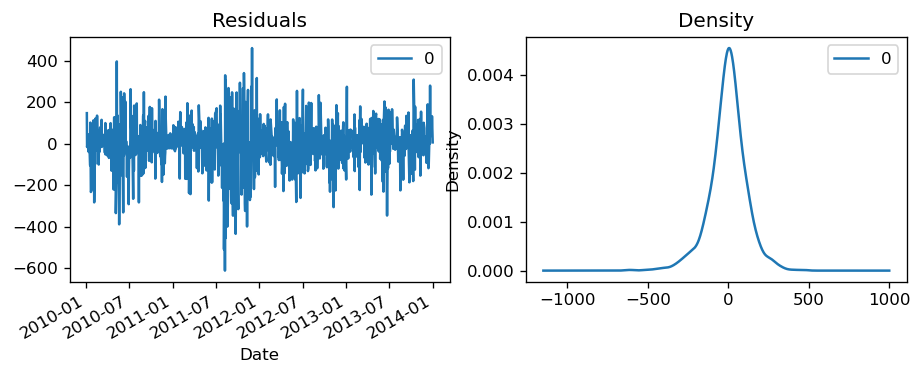

In [13]:
# Plot residual errors. Residuals appear to be centered around 0 with consistent variance.
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

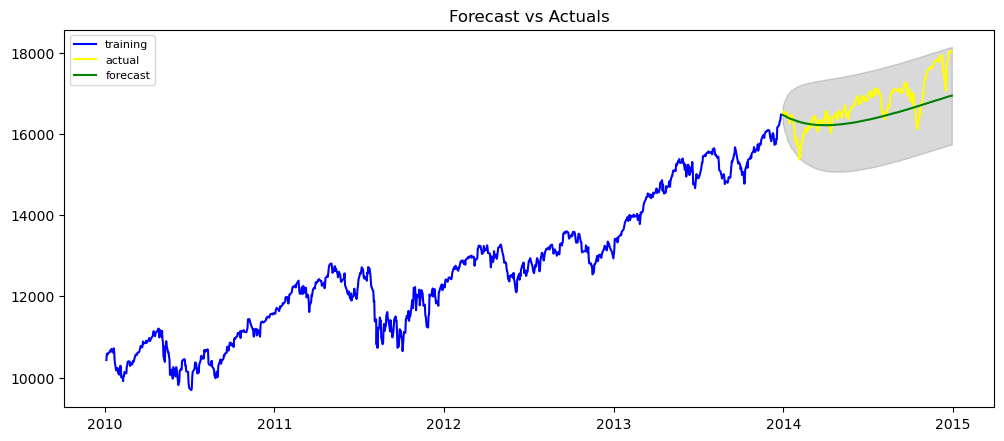

In [14]:
# Forecast
fc, se, conf = model_fit.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training', color='blue')
plt.plot(test, label='actual', color='yellow')
plt.plot(fc_series, label='forecast', color='green')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Predictions appear to catch the general trend farely well. 
# It doesn't do as well predicting the ups and downs occuring during shorter timespans.

In [15]:
# Performance metrics
mse = mean_squared_error(test, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test, fc))
print('RMSE: '+str(rmse))

MSE: 253340.34342924884
MAE: 412.0625656683776
RMSE: 503.32925946069224


## Auto-ARIMA

In [16]:
# Fit auto_arima model
model = auto_arima(train, 
                   start_p=1, start_q=1, # starting p and q
                   max_p=5, max_q=5, # maximum p and q
                   d=None,           # let model determine 'd'
                   seasonal=False,      # add seasonal component
                   m=5,     # unit of seasonality
                   max_P=5, max_Q=5, # maximum p and q for seasonal component
                   D=None,             # order of seasonal differencing: automatically detected 
                   trace=True,
                   #error_action='ignore',  
                   #suppress_warnings=True, 
                   stepwise=True       # Use stepwise function to find optimal parameters.
                   )
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12359.798, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12365.074, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12364.682, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12364.864, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12365.875, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12361.448, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12361.421, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12365.342, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12364.932, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12363.783, Time=0.44 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=12360.796, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.037 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:       

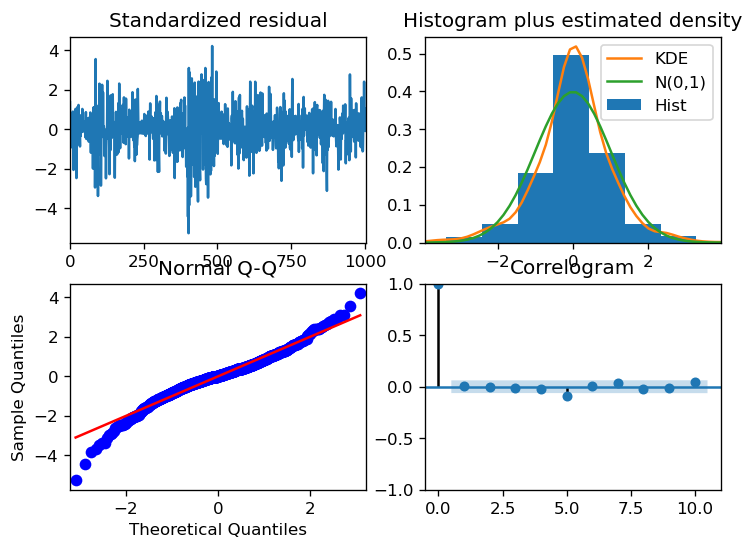

In [17]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

#Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

#Top Right: The density plot suggest normal distribution with mean zero.

#Bottom left: The QQ Plot shots a slight skew, but isn't significant.

#Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

#Overall, it seems to be a good fit. Let’s forecast.

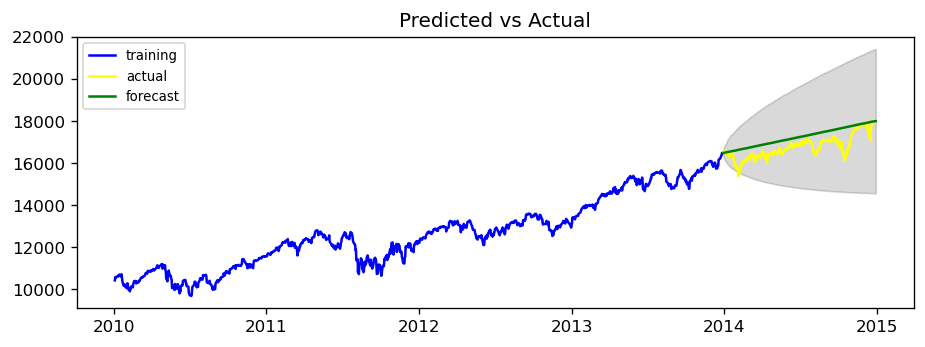

In [18]:
# Forecast
n_periods = len(test)
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = test.index

# Make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot forecast vs. actual
plt.plot(train, color='blue', label='training')
plt.plot(test, color='yellow', label='actual')
plt.plot(fc_series, color='green', label='forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.legend(loc='upper left', fontsize=8)
plt.title("Predicted vs Actual")
plt.show()

In [19]:
# Performance metrics
mse = mean_squared_error(test, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test, fc))
print('RMSE: '+str(rmse))

MSE: 321667.2002744307
MAE: 480.3183141817979
RMSE: 567.1571213292051


## Auto-ARIMA w/ Seasonality

In [20]:
# Fit auto_arima model
model = auto_arima(train, 
                   start_p=1, start_q=1, # starting p and q
                   max_p=5, max_q=5, # maximum p and q
                   d=None,           # let model determine 'd'
                   seasonal=True,      # add seasonal component
                   m=5,     # unit of seasonality
                   max_P=5, max_Q=5, # maximum p and q for seasonal component
                   D=None,             # order of seasonal differencing: automatically detected 
                   trace=True,
                   #error_action='ignore',  
                   #suppress_warnings=True, 
                   stepwise=True       # Use stepwise function to find optimal parameters.
                   )
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[5] intercept   : AIC=12351.002, Time=1.09 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=12365.074, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=12353.545, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=12354.696, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=12365.875, Time=0.01 sec
 ARIMA(1,1,1)(0,0,1)[5] intercept   : AIC=12353.341, Time=0.73 sec
 ARIMA(1,1,1)(1,0,0)[5] intercept   : AIC=12352.568, Time=0.71 sec
 ARIMA(1,1,1)(2,0,1)[5] intercept   : AIC=12351.305, Time=1.75 sec
 ARIMA(1,1,1)(1,0,2)[5] intercept   : AIC=12355.322, Time=1.92 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=12359.798, Time=0.35 sec
 ARIMA(1,1,1)(0,0,2)[5] intercept   : AIC=12353.190, Time=1.67 sec
 ARIMA(1,1,1)(2,0,0)[5] intercept   : AIC=12353.198, Time=1.29 sec
 ARIMA(1,1,1)(2,0,2)[5] intercept   : AIC=12355.567, Time=2.33 sec
 ARIMA(0,1,1)(1,0,1)[5] intercept   : AIC=12354.055, Time=1.02 sec
 ARIMA(1,1,0)(1,0,1

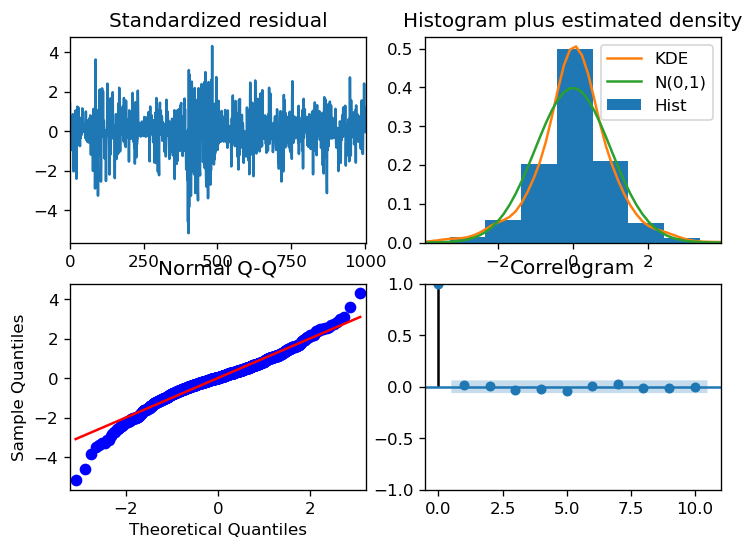

In [21]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

#Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

#Top Right: The density plot suggest normal distribution with mean zero.

#Bottom left: The QQ Plot shots a slight skew, but isn't significant.

#Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

#Overall, it seems to be a good fit. Let’s forecast.

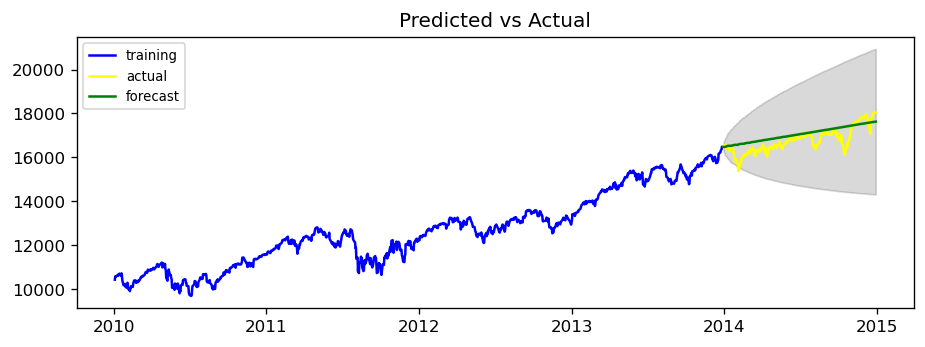

In [22]:
# Forecast
n_periods = len(test)
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = test.index

# Make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot forecast vs. actual
plt.plot(train, color='blue', label='training')
plt.plot(test, color='yellow', label='actual')
plt.plot(fc_series, color='green', label='forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.legend(loc='upper left', fontsize=8)
plt.title("Predicted vs Actual")
plt.show()

In [23]:
# Performance metrics
mse = mean_squared_error(test, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test, fc))
print('RMSE: '+str(rmse))

MSE: 189643.00864736846
MAE: 349.6042828104777
RMSE: 435.48020465615707
